In [36]:
import pandas as pd

# Load the data into a pandas DataFrame
data = pd.read_csv('merged_lz_houston_data.csv', parse_dates=['DateTime'])

# Ensure 'Settlement Point Price' and 'QUANTITY' are treated as numeric columns.
# Coerce any errors during conversion to NaN, which will be handled during the filling process.
# Replace 'Settlement Point Price' with the actual column name from your CSV if it's different.
data['Settlement_Point_Price'] = pd.to_numeric(data['Settlement Point Price'], errors='coerce')
data['QUANTITY'] = pd.to_numeric(data['QUANTITY'], errors='coerce')

# Set 'DateTime' as the index
data.set_index('DateTime', inplace=True)

# Sort the DataFrame by DateTime to ensure it is in chronological order
data.sort_index(inplace=True)

# Resample the data to hourly frequency, aggregating with the mean
# Only numeric columns should be included in this operation.

# Should not Average the Data here, they are separate datasets
account_b_data = data[data["ACCOUNT_NUMBER"] == "account_b"][['Settlement_Point_Price', 'QUANTITY']]
account_a_data = data[data["ACCOUNT_NUMBER"] == "account_a"][['Settlement_Point_Price', 'QUANTITY']]

account_b_data = account_b_data.dropna()
account_a_data = account_a_data.dropna()


In [37]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

# Scale your data using MinMaxScaler to help the LSTM converge faster
scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaled = scaler.fit_transform(account_a_data[['QUANTITY']].values)

# Convert the dataset into sequences of a specific window size
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

# Define the sequence length (number of time steps to look back) and create sequences
seq_length = 4
x, y = sliding_windows(data_scaled, seq_length)

# Convert to PyTorch tensors
dataX = torch.Tensor(x)
dataY = torch.Tensor(y)

# Define the number of splits for cross-validation
n_splits = 4  # For example, you can choose 4-fold cross-validation

# TimeSeriesSplit provides train/test indices to split time series data samples
tscv = TimeSeriesSplit(n_splits=n_splits)

# Iterate over each split
for fold, (train_index, test_index) in enumerate(tscv.split(dataX)):
    # Create training and testing sets for this fold
    trainX, trainY = dataX[train_index], dataY[train_index]
    testX, testY = dataX[test_index], dataY[test_index]
    
    # Create DataLoader instances for training and testing sets
    batch_size = 64  # You can adjust the batch size
    train_dataset = TensorDataset(trainX, trainY)
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    
    test_dataset = TensorDataset(testX, testY)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


ModuleNotFoundError: No module named 'torch'

In [36]:
import torch.nn as nn

# Define the LSTM Model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate the LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        
        return out

The LSTM class is defined with parameters for input size, hidden size, output size, and the number of layers.
The forward method initializes the hidden state h0 and cell state c0 with zeros for each batch, ensuring they are on the same device as the input tensor x.
The LSTM output out is passed through a fully connected layer to produce the final output.
The hidden and cell states are detached from the graph after each batch to prevent backpropagation through the entire sequence of states (which is not needed and would significantly increase memory usage).

In [38]:
import torch

# Model initialization and training configuration
num_epochs = 1000
learning_rate = 0.01

input_size = 1  # This should match the last dimension of your input data
hidden_size = 2
num_layers = 1

output_size = 1  # Since you are predicting a single value

# Instantiate the model
lstm = LSTM(input_size, hidden_size, output_size, num_layers)
lstm = lstm.cuda()  # Ensure model is on CUDA

# Loss and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    lstm.train()  # Set model to training mode
    total_loss = 0

    for seq, labels in train_loader:
        # Move data to CUDA
        seq, labels = seq.cuda(), labels.cuda()
        #print(f"Input shape: {seq.shape}")  # Add this line to check input shape
        #outputs = lstm(seq)
        # Forward pass
        outputs = lstm(seq)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    if epoch % 100 == 0:  # Print average loss every 100 epochs
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}')

# After training, you might want to save your model
# torch.save(lstm.state_dict(), 'lstm_model.pth')

# Evaluation
lstm.eval()  # Set model to evaluation mode
test_losses = []
with torch.no_grad():
    for seq, labels in test_loader:
        seq, labels = seq.cuda(), labels.cuda()
        outputs = lstm(seq)
        loss = criterion(outputs, labels)
        test_losses.append(loss.item())

average_test_loss = sum(test_losses) / len(test_losses)
print(f'Average Test Loss: {average_test_loss:.4f}')

Epoch [0/1000], Loss: 0.0692
Epoch [100/1000], Loss: 0.0127
Epoch [200/1000], Loss: 0.0122
Epoch [300/1000], Loss: 0.0121
Epoch [400/1000], Loss: 0.0117
Epoch [500/1000], Loss: 0.0118
Epoch [600/1000], Loss: 0.0117
Epoch [700/1000], Loss: 0.0118
Epoch [800/1000], Loss: 0.0119
Epoch [900/1000], Loss: 0.0118
Average Test Loss: 0.0272


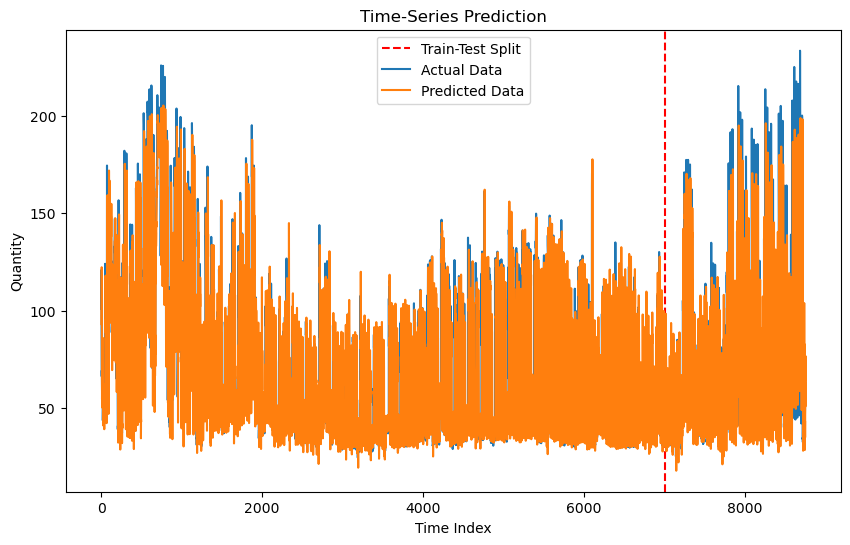

In [45]:
from matplotlib import pyplot as plt

# Assuming lstm, trainX, testX are defined and loaded with the correct data
lstm.eval()  # Set the model to evaluation mode

# Generate predictions for both training and test sets
train_predict = lstm(trainX.cuda())
test_predict = lstm(testX.cuda())

# Concatenate train and test predictions for full data visualization
full_predict = torch.cat((train_predict, test_predict), 0)

# Inverse transform the predictions and actual data
data_predict = scaler.inverse_transform(full_predict.data.cpu().numpy())
dataY_plot = scaler.inverse_transform(dataY.data.cpu().numpy())

# Calculate the splitting point in the plot for visualizing train-test separation
split_pt = trainX.size(0) + seq_length  # Account for the sequence length

# Plotting
plt.figure(figsize=(10,6))
plt.axvline(x=split_pt, c='r', linestyle='--', label='Train-Test Split')

# Actual data
plt.plot(dataY_plot, label='Actual Data')

# Predictions (overlay on the actual data)
plt.plot(np.arange(seq_length, len(data_predict)+seq_length), data_predict, label='Predicted Data')

plt.title('Time-Series Prediction')
plt.xlabel('Time Index')
plt.ylabel('Quantity')
plt.legend()
plt.show()

In [41]:
# Calculate the mean squared error
mse = np.mean(np.square(dataY_plot - data_predict))
print("Mean Squared Error: %1.5f" % mse)
# Calculate the root mean squared error
rmse = np.sqrt(mse)
print("Root Mean Squared Error: %1.5f" % rmse)

Mean Squared Error: 160.45959
Root Mean Squared Error: 12.66726


In [44]:
# Save the model's state dictionary
torch.save(lstm.state_dict(), 'lstm_model_state_dict.pth')

# Predict Price with Weather data

Import Related Libraries

In [100]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm

Load in and merge weather data

In [101]:
# Load in Weather and IGS data
igs_data = pd.read_csv("updated_igs_data.csv", index_col = 0)
hourly_weather = pd.read_csv("houston_hourly_weather_data.csv")

# Merge Data
hourly_weather["datetime"] = pd.to_datetime(hourly_weather["datetime"])
igs_data["LOCAL_FROM_DATETIME"] = pd.to_datetime(igs_data["LOCAL_FROM_DATETIME"])
price_df = igs_data.merge(hourly_weather, how = "left", left_on = "LOCAL_FROM_DATETIME", right_on = "datetime")

Clean Merged Data

In [102]:

# Rename and Add Columns
price_df.rename(columns = {"Delivery Date":"DateTime"}, inplace = True)
price_df["Month_Int"] = price_df["LOCAL_FROM_DATETIME"].apply(lambda d: d.month)

#Replace 'Settlement Point Price' with the actual column name from your CSV if it's different.
price_df['Settlement_Point_Price'] = pd.to_numeric(price_df['Settlement Point Price'], errors='coerce')
price_df['QUANTITY'] = pd.to_numeric(price_df['QUANTITY'], errors='coerce')

# Set 'DateTime' as the index
price_df.set_index('DateTime', inplace=True)

# Sort the DataFrame by DateTime to ensure it is in chronological order
price_df.sort_index(inplace=True)

# Prices are the same for each account so we can take prices from a single account
price_df = price_df[price_df["ACCOUNT_NUMBER"] == "account_a"][["Settlement_Point_Price", "Month_Int", "Hour", "Holiday", "Day", "Weekend", "temp"]]
price_df = price_df.dropna()

# Change Boolean values to floats
price_df = price_df.astype(float)

Function to create sequences of data

In [103]:
def create_sequences(data, seq_length):
    xs = []
    ys = []

    # Create Rolling Windows
    for i in range(len(data) - seq_length):
        xs.append(data.iloc[i:(i + seq_length)])
        ys.append(data.iloc[i + seq_length])

    # Torch Arrays
    xs = torch.tensor(np.array(xs), dtype=torch.float32)
    ys = torch.tensor(np.array(ys), dtype=torch.float32)
    
    # Only need price for Y
    ys = ys[:,:1]
    
    return xs, ys

Our LSTM Model Architecture:

In [104]:
class CustomLSTM(nn.Module):
    def __init__(self, lstm_input_size, hidden_size, num_layers, output_size, aux_input_size = None, aux_hidden_size = None):
        super(CustomLSTM, self).__init__()

        # LSTM Layer
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(lstm_input_size, hidden_size, num_layers, batch_first=True)
        
        # Linear layer code:
        #self.aux_lin = torch.nn.Linear(aux_input_size, aux_hidden_size)

        ## Join Layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x_time):

        h_0 = torch.zeros(self.num_layers, x_time.size(0), self.hidden_size).to(device)
        c_0 = torch.zeros(self.num_layers, x_time.size(0), self.hidden_size).to(device)

        # LSTM Output
        out, _ = self.lstm(x_time, (h_0, c_0))

        # Transform into output
        out = self.fc(out[:, -1, :])

        return out

Dataset Initialization

In [105]:
# Create Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create Sequences to look at past three days of data. (Arbitrary selection)
seq_length = 72  
X, Y = create_sequences(price_df, seq_length)

# We throw out the first three days of every month becuase they would capture 
# information about the validation data and we don't want this so we remove them

# Days of the month greater than or equal to 25
val_condition = X[:,0,4] >= 25
# Days of the month between 3 and 25 exclusively
train_condition = (X[:,0,4] > 3) & (X[:,0,4] < 25)

# Train Test Splits
X_train = X[train_condition]
Y_train = Y[train_condition]
X_test = X[val_condition]
Y_test = Y[val_condition]

Model Initalization:

In [128]:
# Hyperparameters
input_size = X_train.shape[-1]  # Number of lstm input features
hidden_size = 50  # Number of features in hidden state
num_layers = 3  # Number of stacked LSTM layers
output_size = 1  # Number of output values
num_epochs = 1000
learning_rate = 0.001

# Initalize Model
model = CustomLSTM(input_size, hidden_size, num_layers, output_size)
model = model.to(device)

# Set up loss and optimizer
criterion = torch.nn.MSELoss(reduction = "mean")
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

This is the training loop

In [129]:
train_loss_log = []
val_loss_log = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    output = model(X_train.to(device))
    loss = criterion(output.view(-1), Y_train.to(device).view(-1))
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    train_loss_log.append(loss.item())

    # Validation Loss:
    model.eval()
    with torch.no_grad():
        Y_Test_pred = model(X_test.to(device))
        val_loss = criterion(Y_Test_pred.view(-1), Y_test.view(-1))
        val_loss_log.append(val_loss.item())
        
    if (epoch+1) % 100 == 0:
        print(f'Epoch {epoch+1}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')

100%|██████████| 10/10 [00:23<00:00,  2.33s/it]


Plot the Learning Curves

Text(0.5, 1.0, 'Price LSTM Training Curves')

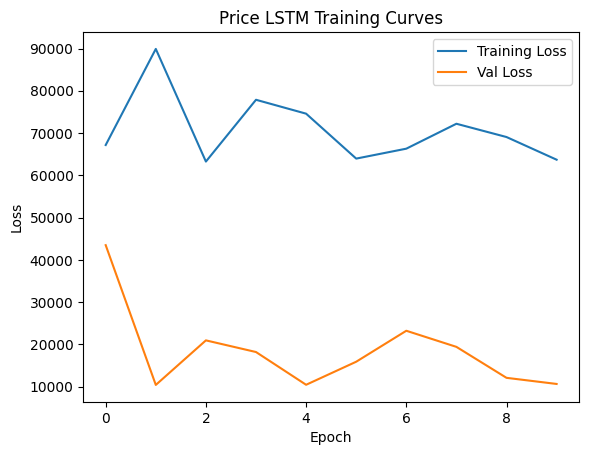

In [130]:
import matplotlib.pyplot as plt

plt.plot(train_loss_log, label = "Training Loss")
plt.plot(val_loss_log, label = "Val Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Price LSTM Training Curves")

Plot Predictions

Test RMSE: 103.09490564675104


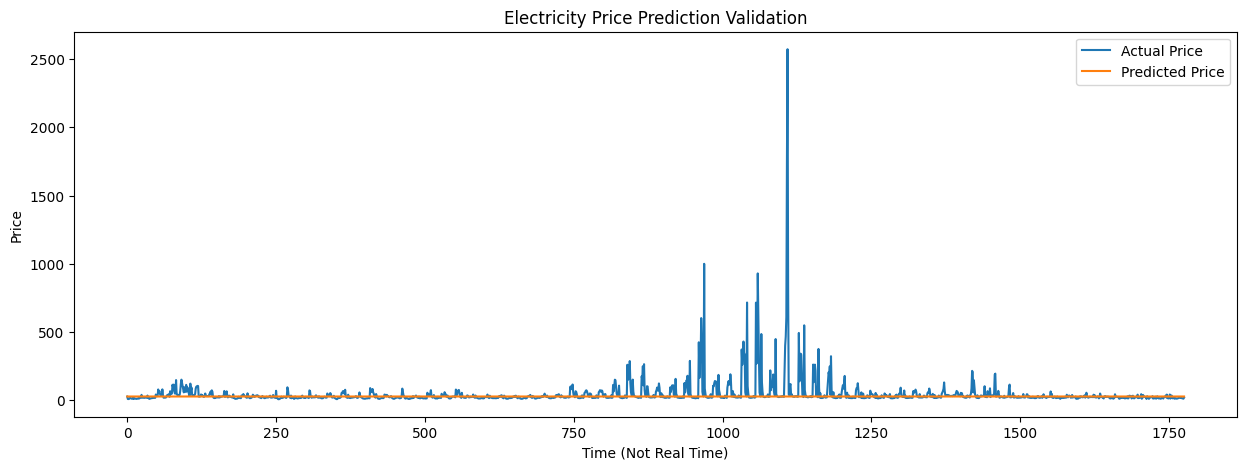

In [133]:
model.eval()
with torch.no_grad():
    Y_test_pred = model(X_test)
    
# y_test_pred = y_test_pred.cpu().numpy()
# y_test = y_test.to.numpy()


# Calculate RMSE
rmse = np.sqrt(criterion(Y_test, Y_test_pred).item())
print(f'Test RMSE: {rmse}')

plt.figure(figsize=(15, 5))
plt.plot(Y_test, label='Actual Price')
plt.plot(Y_test_pred, label='Predicted Price')
plt.title('Electricity Price Prediction Validation')
plt.xlabel('Time (Not Real Time)')
plt.ylabel('Price')
plt.legend()
plt.show()

Potential future assessments:

1. Plot fitted values when using the feature vector in LSTM